In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.constants import m_e, e ,c 
from astropy import units as u
from scipy.constants import physical_constants

In [2]:
C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772  # cm

cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

f_CIV_K = 0.190
f_CIV_H = 0.0952
K_gamma = 2.65e+8
H_gamma = 2.64e+8
NN = int(1e4)
xx = np.linspace(-10, 10, NN)
yy = np.linspace(-20,20, NN)

rr = np.arange(10, 50, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]



total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)


def tau(sig_c, x):
    return sig_c * x

def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def total_tau(v_th,C_IV):
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV)
    tau_profile = tau(sig_c, total_N_c[:, None]) * Voigt_profile
    return tau_profile


def scatter_cross_section(v_th):
    # m_e = m_e.to(u.g) # cm
    cc = c.to(u.cm/u.s).value
    r_e = physical_constants["classical electron radius"][0]*1e2 # cm
    f_total = f_CIV_K + f_CIV_H
    del_D_K = v_th/C_IV_K
    del_D_H = v_th / C_IV_H 
    Voigt_H = Voigt(xx,v_th,H_gamma, C_IV_H)
    Voigt_K = Voigt(xx,v_th,K_gamma, C_IV_K)
    result = (np.sqrt(np.pi) / f_total) * (r_e)*cc* ((f_CIV_K/del_D_K )*Voigt_H +(f_CIV_H/del_D_H )*Voigt_K  )
    return result




8.068033119843106e-14


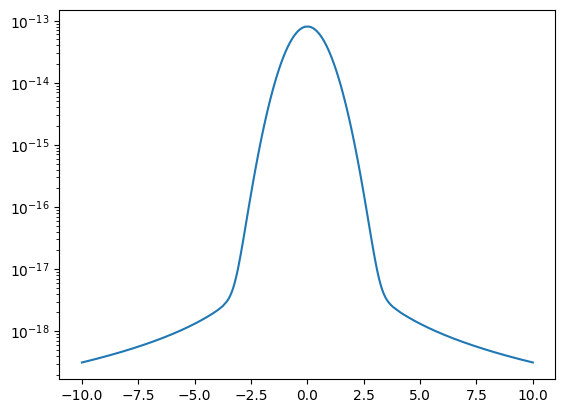

In [3]:
cross_section = scatter_cross_section(v_th_CIV)
plt.plot(xx,cross_section)
print(cross_section.max())
plt.yscale('log')

In [4]:
NN = int(10000)
yy = np.linspace(-1000,1000, NN)
def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    yy = np.linspace(int(2*xx.min()),int(2*x.max()),NN)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def scatter_cross_section(v_th,lam):
    # m_e = m_e.to(u.g) # cm
    cc = c.to(u.cm/u.s).value
    r_e = physical_constants["classical electron radius"][0]*1e2 # cm
    f_total = f_CIV_K + f_CIV_H
    del_D_K = v_th/C_IV_K
    del_D_H = v_th / C_IV_H
    xx_K = (1/lam - 1/C_IV_K_A) *cc *1e8/ del_D_K 
    xx_H = (1/lam - 1/C_IV_H_A) *cc *1e8/ del_D_H 
    Voigt_H = Voigt(xx_H,v_th,H_gamma, C_IV_H)
    Voigt_K = Voigt(xx_K,v_th,K_gamma, C_IV_K)
    result = (np.sqrt(np.pi) / f_total) * (r_e)*cc* ((f_CIV_H/del_D_K )*Voigt_H +(f_CIV_K/del_D_H )*Voigt_K  )
    return xx_H,result

In [5]:

x_lambda = np.linspace(C_IV_K_A-2.5,C_IV_H_A+2.5,NN)
xx,cross_section = scatter_cross_section(v_th_CIV,x_lambda)
xx


array([ 83.81323747,  83.80069316,  83.78814886, ..., -40.9800512 ,
       -40.99247333, -41.00489543])

(1e-21, 1e-11)

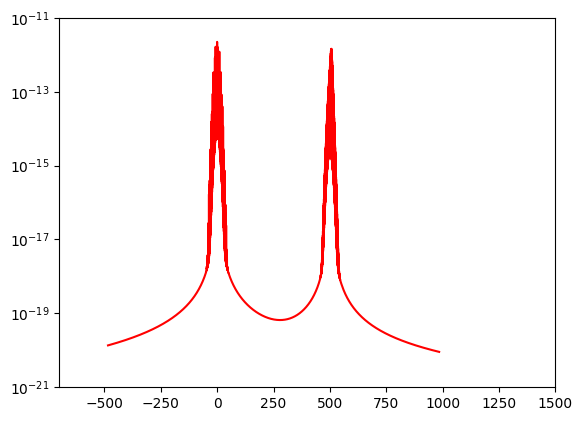

In [6]:
aa,cross_section = scatter_cross_section(v_th_CIV,x_lambda)
# bb,cross_section_1 = scatter_cross_section(v_th_CIV/10,x_lambda)
vel_space= ((x_lambda - C_IV_K_A) / C_IV_K_A)* cc_k

plt.plot(vel_space, cross_section,'r')
# plt.plot(vel_space, cross_section_1,'r--')
plt.yscale('log')
plt.xlim(-700,1500)
plt.ylim(10e-22,10e-12)

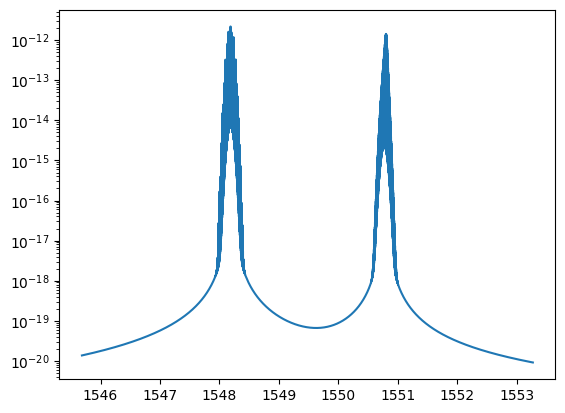

In [7]:
plt.plot(x_lambda,cross_section)
plt.yscale('log')

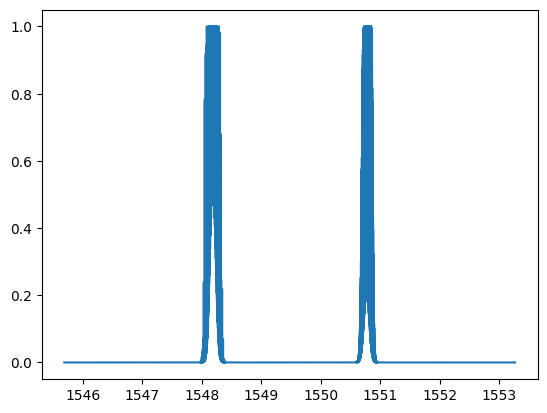

In [8]:
tau_cc = cross_section * 1e14

Flam = (1-np.exp(-tau_cc))
plt.plot(x_lambda,Flam )

([<matplotlib.axis.XTick at 0x75cbd3f4c6d0>,
 [Text(11, 0, '11'),
  Text(13, 0, '13'),
  Text(15, 0, '15'),
  Text(17, 0, '17'),
  Text(19, 0, '19')])

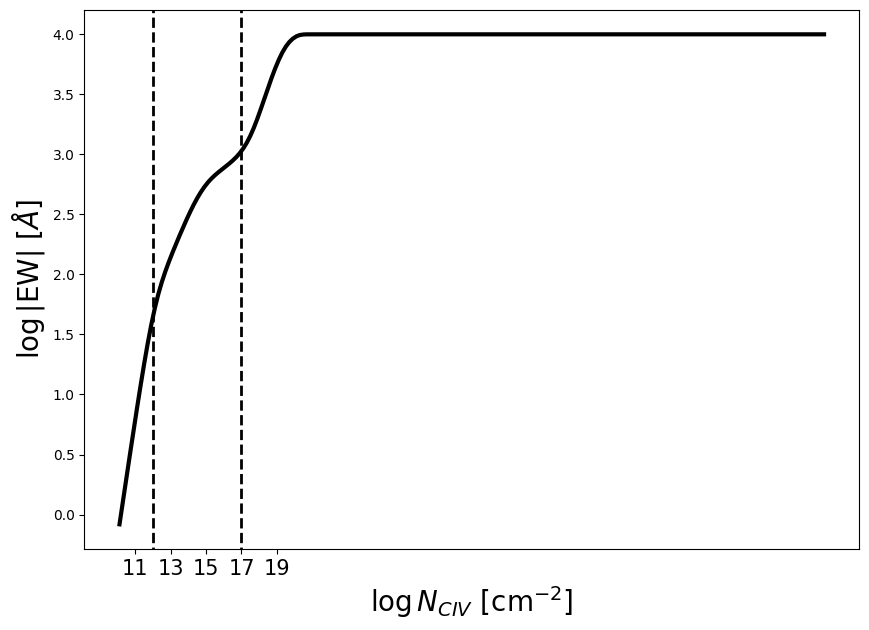

In [9]:
plt.figure(1,figsize=(10,7))
# plt.subplot(121)
dx = x_lambda[1] - x_lambda[0]
EW = np.zeros(len(total_N_c))
for ii,column_density in enumerate(total_N_c):
    
    tau_cc = cross_section * column_density

    EW[ii] = np.sum((1-np.exp(-tau_cc)))

plt.plot(np.log10(total_N_c),np.log10(EW),'k-',lw=3)
plt.axvline(x=12,ymin=-10,ymax=10,linestyle='--',color='k',lw=2)
plt.axvline(x=17,ymin=-10,ymax=10,linestyle='--',color='k',lw=2)
# plt.xlim(10.5,19.5)
plt.xlabel(r'$\log{N_{CIV}} ~ [\rm cm^{-2}]$',fontsize=20)
plt.ylabel(r'$\log{\rm |EW|}$ $[\AA]$',fontsize=20)
plt.xticks([11,13,15,17,19],fontsize=15)
# plt.yticks([-2,-1,0,1,2],fontsize=15)
# plt.ylim(-2.2,2.2)
# plt.subplot(122)
# tau_change = sig_c*total_N_c 

# plt.plot(np.log10(tau_change),np.log10(EW),'k-',lw=3)
# plt.axvline(x=np.log10(1e12*sig_c),ymin=-10,ymax=10,linestyle='--',color='k')
# plt.axvline(x=np.log10(1e17*sig_c),ymin=-10,ymax=10,linestyle='--',color='k')
# plt.xlabel(r'$\log{\tau_0}$',fontsize=20)
# plt.ylabel(r'$\log{\rm EW}$ $[\rm cm^2]$',fontsize=20)
# plt.xticks(fontsize=15)
# plt.yticks([-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5],fontsize=15)

# plt.savefig(r'/home/jin/바탕화면/curve_of_growth.pdf',bbox_inches='tight')

In [10]:
m_e = m_e.to(u.g).value # cm
cc = c.to(u.cm/u.s).value
e = 1.602e-19
e**2/m_e / cc
# r = (e*e/(m_e*cc**2))
# print(r)

np.float64(9.397564711561714e-22)

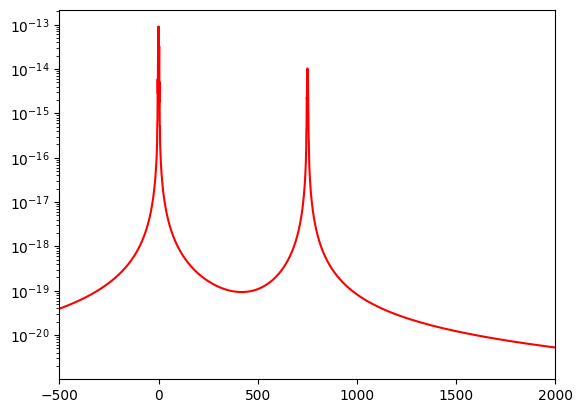

In [12]:
NN = int(5000)
# yy = np.linspace(-5000,5000, NN)

def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    yy = np.linspace(int(2*x.min()),int(2*x.max()),NN)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def scatter_cross_section(v_th,lam):
    cc = c.to(u.cm/u.s).value
    r_e = physical_constants["classical electron radius"][0]*1e2 # cm
    f_total = f_k + f_h
    del_D_K = v_th/Mg_K
    del_D_H = v_th / Mg_H
    xx_K = (1/lam - 1/Mg_K_A) *cc *1e8/ del_D_K 
    xx_H = (1/lam - 1/Mg_H_A) *cc *1e8/ del_D_H 
    Voigt_H = Voigt(xx_H,v_th,gamma_H, Mg_H)
    Voigt_K = Voigt(xx_K,v_th,gamma_K, Mg_K)
    result = (np.sqrt(np.pi) / f_total) * (r_e)*cc* ((f_h/del_D_H )*Voigt_H +(f_k/del_D_K )*Voigt_K  )
    return xx_K,result

f_k = 0.608
f_h= 0.303
gamma_K = 2.6e8
gamma_H =2.57e8 

mg_h_nu = 1.067e15
mg_k_nu = 1.0724e15

Mg_K = 2796e-8
Mg_H = 2803e-8

Mg_K_A = 2796
Mg_H_A = 2803
Cen = (Mg_K_A+Mg_H_A) / 2
ll = np.linspace(Cen-22,Cen +22,NN)

vth_mg = 15e5
bb,aa = scatter_cross_section(vth_mg,ll)

vth_mg = 2.7e5
bb,cc = scatter_cross_section(vth_mg,ll)

vel_s = (ll/Mg_K_A -1 ) * cc_k
# plt.plot(vel_s,aa,'r--')
plt.plot(vel_s,cc,'r')
plt.xlim(-500,2000)
plt.yscale('log')
# plt.ylim(10e-21,10e-12)
# print(bb)

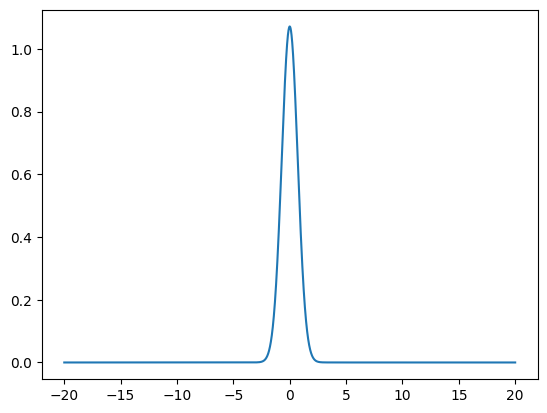

In [13]:

NN = int(1e4)
xx = np.linspace(-20, 20, NN)
yy = np.linspace(-20,20, NN)
cc = c.to(u.cm/u.s).value

f_k = 0.608
f_h= 0.303
gamma_K = 2.6e8
gamma_H =2.57e8 

mg_h_nu = 1.067e15
mg_k_nu = 1.0724e15

Mg_K = 2796e-8
Mg_H = 2803e-8

Mg_K_A = 2796
Mg_H_A = 2803

vth_mg = 2.7e5


def Voigt(x,v_th,gamma_line, lines,yy):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return del_lam_D, summ * a / np.pi


del_lam_D_K,Voigt_K = Voigt(xx,vth_mg,gamma_K,Mg_K,yy)
del_lam_D_H,Voigt_H = Voigt(xx,vth_mg,gamma_H,Mg_H,yy)

tt = cc / ((del_lam_D_K * 10) + (cc / Mg_K)) 
# print(tt-mgk)
plt.plot(xx,Voigt_H)

[1.14782683e-22 1.14828823e-22 1.14874990e-22 ... 1.51466530e-22
 1.51405472e-22 1.51344453e-22]


(-5.0, 5.0)

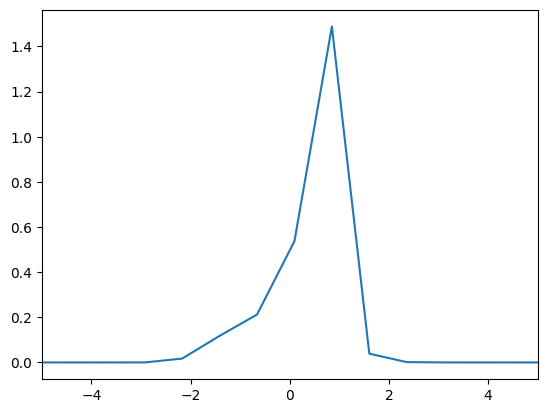

In [70]:
# def Voigt(x, v_th, gamma_line, lines, yy):
#     del_lam_D = v_th / lines
#     a = gamma_line / (4 * np.pi * del_lam_D)
#     dy = np.abs(yy[1] - yy[0])
    
#     # Calculations for single x value
#     qq_minus_yy_squared = (x - yy) ** 2
#     exp_neg_yy_squared = np.exp(-yy ** 2)
    
#     summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a ** 2))
    
#     return summ * a / np.pi


def Voigt(x, v_th, gamma_line, lines, yy):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi


f_k = 0.608
f_h= 0.303
gamma_K = 2.6e8
gamma_H =2.57e8 

mg_h_nu = 1.067e15
mg_k_nu = 1.0724e15

Mg_K = 2796e-8
Mg_H = 2803e-8

Mg_K_A = 2796
Mg_H_A = 2803

vth_mg = 2.7e5

del_lam_D_K = vth_mg / Mg_K
del_lam_D_H = vth_mg / Mg_H

r_e = physical_constants["classical electron radius"][0]*1e2 # cm

NN = int(1e4)
lam = np.linspace(2700,2890,NN)

x_k = ((1/lam - 1/Mg_K_A) * cc* 1e8) / del_lam_D_K

x_h = ((1/lam - 1/Mg_H_A) * cc* 1e8) / del_lam_D_H


yy = np.linspace(-100,100,NN)

Voigt_K = Voigt(x_k, vth_mg, gamma_K, Mg_K, yy)
Voigt_H = Voigt(x_h, vth_mg, gamma_H, Mg_H, yy)


const= ((r_e*cc) * np.sqrt(np.pi) / (f_k + f_h))

k_terms = (f_k/del_lam_D_K ) *Voigt_K
h_terms = (f_h/del_lam_D_H ) *Voigt_H

Total_sc= const*(k_terms + h_terms)
print(Total_sc)
plt.plot(x_k,Voigt_K)
plt.xlim(-5,5)

([<matplotlib.axis.YTick at 0x75cb96339540>,
 [Text(0, 1e-20, '$\\mathdefault{10^{-20}}$'),
  Text(0, 1e-18, '$\\mathdefault{10^{-18}}$'),
  Text(0, 1e-16, '$\\mathdefault{10^{-16}}$'),
  Text(0, 1e-14, '$\\mathdefault{10^{-14}}$'),
  Text(0, 1e-12, '$\\mathdefault{10^{-12}}$')])

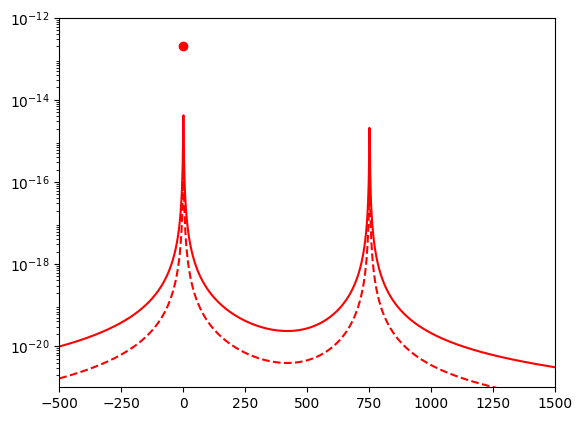

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants, c as cc

def Voigt(x, v_th, gamma_line, lines, yy):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

# Constants and inputs
f_k = 0.608
f_h = 0.303
gamma_K = 2.6e8
gamma_H = 2.57e8 
mg_h_nu = 1.067e15
mg_k_nu = 1.0724e15
Mg_K = 2796e-8
Mg_H = 2803e-8
Mg_K_A = 2796
Mg_H_A = 2803

NN = int(1e4)
lam = np.linspace(2750, 2850, NN)

def scs(lam,vth):

    r_e = physical_constants["classical electron radius"][0] * 1e2  # cm

    # Calculate del_lam_D_K and del_lam_D_H
    del_lam_D_K = vth / Mg_K
    del_lam_D_H = vth / Mg_H

    # Calculate x_k and x_h
    x_k = ((1 / lam - 1 / Mg_K_A) * cc * 1e8) / del_lam_D_K
    x_h = ((1 / lam - 1 / Mg_H_A) * cc * 1e8) / del_lam_D_H

    # Adjust yy range based on a factor of gamma and del_lam_D_K
    a_K = gamma_K / (4 * np.pi * del_lam_D_K)
    a_H = gamma_H / (4 * np.pi * del_lam_D_H)
    # NN = 1e5
    yy_k = np.linspace(-1 * a_K, 1 * a_K, NN)  # Adjusting yy range based on a_K
    yy_h =  np.linspace(-1* a_H, 1 * a_H, NN)

    # Calculate Voigt profiles
    Voigt_K = Voigt(x_k, vth, gamma_K, Mg_K, yy_k)
    Voigt_H = Voigt(x_h, vth, gamma_H, Mg_H, yy_k)

    # Combine and plot
    const = ((r_e * cc) * np.sqrt(np.pi) / (f_k + f_h))
    k_terms = (f_k / del_lam_D_K) * Voigt_K
    h_terms = (f_h / del_lam_D_H) * Voigt_H
    Total_sc = const * (k_terms + h_terms)
    return Total_sc

vel_s = (lam/Mg_K_A-1)*cc_k
vth_mg = 2.6e5
aa = scs(lam,vth_mg)
vth_mg = 15.6e5
bb = scs(lam,vth_mg)
plt.plot(vel_s,aa,'r-')
plt.plot(vel_s,bb,'r--')
plt.yscale('log')
plt.xlim(-500,1500)
plt.plot(0,2*1e-13,'ro')
plt.ylim(10e-22,10e-13)
plt.yticks([1e-20,1e-18,1e-16,1e-14,1e-12])

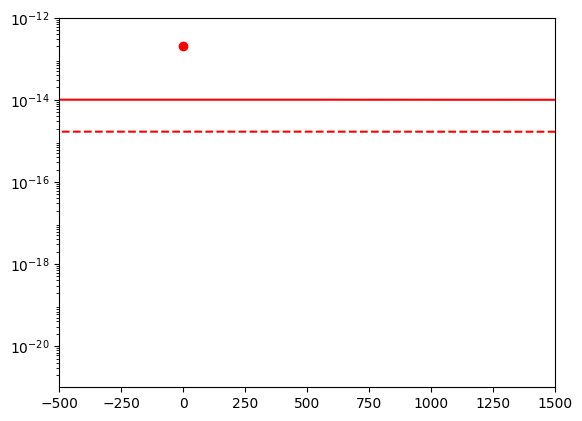

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants, c as cc

def Voigt(x, v_th, gamma_line, lines, yy):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

# Constants and inputs
f_k = 0.608
f_h = 0.303
gamma_K = 2.6e8
gamma_H = 2.57e8 
mg_h_nu = 1.067e15
mg_k_nu = 1.0724e15
Mg_K = 2796e-8
Mg_H = 2803e-8
Mg_K_A = 2796
Mg_H_A = 2803

NN = int(1e4)
lam = np.linspace(2750, 2850, NN)

def scs(lam, vth):

    r_e = physical_constants["classical electron radius"][0] * 1e2  # cm

    # Calculate del_lam_D_K and del_lam_D_H
    del_lam_D_K = vth / Mg_K
    del_lam_D_H = vth / Mg_H

    # Calculate x_k and x_h
    x_k = ((1 / lam - 1 / Mg_K_A) * cc * 1e8) / del_lam_D_K
    x_h = ((1 / lam - 1 / Mg_H_A) * cc * 1e8) / del_lam_D_H

    # Adjust yy range based on a factor of gamma and del_lam_D_K
    a_K = gamma_K / (4 * np.pi * del_lam_D_K)
    a_H = gamma_H / (4 * np.pi * del_lam_D_H)

    # Reduced yy range
    yy_k = np.linspace(-10 * a_K, 10 * a_K, NN)  
    yy_h = np.linspace(-10 * a_H, 10 * a_H, NN)

    # Calculate Voigt profiles
    Voigt_K = Voigt(x_k, vth, gamma_K, Mg_K, yy_k)
    Voigt_H = Voigt(x_h, vth, gamma_H, Mg_H, yy_h)

    # Combine and plot
    const = ((r_e * cc) * np.sqrt(np.pi) / (f_k + f_h))
    k_terms = (f_k / del_lam_D_K) * Voigt_K
    h_terms = (f_h / del_lam_D_H) * Voigt_H
    Total_sc = const * (k_terms + h_terms)
    return Total_sc

vel_s = (lam / Mg_K_A - 1) * cc
vth_mg = 2.6e5
aa = scs(lam, vth_mg)
vth_mg = 15.6e5
bb = scs(lam, vth_mg)

# Plotting
plt.plot(vel_s, aa, 'r-')
plt.plot(vel_s, bb, 'r--')
plt.yscale('log')
plt.xlim(-500, 1500)
plt.plot(0, 2 * 1e-13, 'ro')
plt.ylim(1e-21, 1e-13)
plt.yticks([1e-20, 1e-18, 1e-16, 1e-14, 1e-12])
plt.show()
